In [1]:
%load_ext autoreload

In [2]:
#imports
%autoreload 2
import os
os.chdir('/home/kitouni/projects/Geometric-HEP/pythia-gen/')
import pandas as pd
import flow
from flow import LightningModel, PTLoss, EFNHybrid
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import dense_to_sparse
import torch
import numpy as np
from matplotlib import pyplot as plt
plt.style.use("dark_paper")

In [3]:
def readme(path, string):
    with open(os.path.join(path,'readme.txt'), 'w') as f:
        f.write(string)
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
def trim_df(df,index):
    return df[(df['STATUS']>0)&(df['EVENT']==index)].iloc[1:]
def process(df,target,scalars):
    vec4 = df[df['STATUS']>0][["E","px","py","pz"]].iloc[1:].values
    x = vec4[:,1:]/vec4[:,0].reshape(-1,1)
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(target).float().view(1,4)
#     distances = getDR(x)
#     edge_index=torch_geometric.nn.radius_graph(distances,r=1)#GCNConv adds self loops
#     edge_index=dense_to_sparse(torch.ones(x.shape[0],x.shape[0]).fill_diagonal_(0))[0]#complete
    edge_index=dense_to_sparse(torch.eye(x.shape[0]))[0]#self only
#     edge_index=dense_to_sparse(torch.ones(x.shape[0],x.shape[0]))[0]#complete graph
#    edge_index=None
    data = Data(x=x, y=y, edge_index=edge_index) 
    data.p = torch.from_numpy(vec4).float()
    data.scalars = torch.Tensor(scalars).float().view(1,4)
    return data

# Load Data

In [6]:
events_breit = pd.read_hdf('data/EIC/breit0.h5', key=f'data')
targets = pd.read_hdf("data/EIC/targets_breit0.h5",key='data').values
scalars = pd.read_hdf("data/EIC/scalars0.h5",key='data').values

In [ ]:
train_set = [process(events_breit[events_breit['EVENT']==i],y,z) for i,y,z in zip(range(10000),targets,scalars)]
train_loader = DataLoader(train_set, batch_size=10,shuffle=True, num_workers=12)

In [ ]:
val_set = [process(events_breit[events_breit['EVENT']==i],y,z) for i,y,z in zip(range(10000,11000),targets[10000:11000],scalars[10000:11000])]
val_loader = DataLoader(val_set, batch_size=1,shuffle=False, num_workers=12)

In [ ]:
# Gather some statistics about the first graph.
data = train_set[1]  # Get the first graph object.
print(data)
print('=============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

# Instantiate network and train

In [ ]:
torch.manual_seed(0)
hidden_channels = 128
nn = torch.nn.Sequential(torch.nn.Linear(3+4,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.BatchNorm1d(hidden_channels),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),                                       
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Dropout(0.5),
                         torch.nn.Linear(hidden_channels,1),
                         torch.nn.Sigmoid())

nn2 = torch.nn.Sequential(torch.nn.Linear(3,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.BatchNorm1d(hidden_channels),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Dropout(0.5),
                         torch.nn.Linear(hidden_channels,1),
                         torch.nn.Sigmoid())

efn = EFNHybrid(local_nn=nn, global_nn=nn2)

#efn_script = torch.jit.script(efn)
optim  = torch.optim.Adam(efn.parameters(),weight_decay=0,lr=1e-5)
module = Model(efn, optim=optim,
               criterion=PTLoss(torch.nn.MSELoss()))

In [ ]:
# Run
logdir = "./lightning_logs/segmentation"
mkdir(logdir)
name = "hybrid"
log = flow.utils.Logger(logdir, name=name,default_hp_metric=False)
checkpoint_path = os.path.join(logdir,f"{name}/version_{log.version}")
checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
bar = flow.utils.ProgressBar()
pl.seed_everything(42)
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=200, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(module,train_dataloader=train_loader,val_dataloaders=val_loader)
readme(checkpoint_path, "Large dataset 10k")

# Plotting

In [ ]:
#get weights
efn.to("cuda:0")
weights = list()
theta = list()
phi = list()
pt = list()
E = list()
for i in range(len(train_set)):
    batch = train_set[i]
    batch.to("cuda:0")
    with torch.no_grad():
        weights.append(efn(batch).cpu().numpy())
    theta.append(trim_df(events_breit,i)['theta'].values)
    phi.append(trim_df(events_breit,i)['phi'].values)
    pt.append(np.abs(trim_df(events_breit,i)['pT'].values).sum())
    E.append(trim_df(events_breit,i)['E'].values)
theta = np.array(theta,dtype='object')
phi = np.array(phi,dtype='object')
E = np.array(E,dtype='object')
weights = np.array(weights,dtype='object')
pt = np.array(pt)

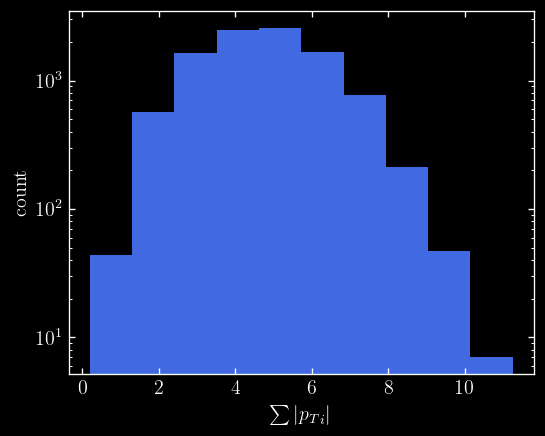

In [42]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi=120)
out = plt.hist(pt)
plt.yscale('log')
plt.xlabel(r"$\sum|{p_T}_i|$")
plt.ylabel("count")
plt.show()

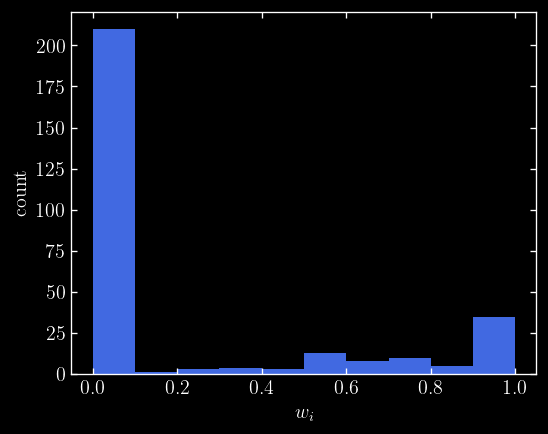

In [65]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi=120)
plt.hist(np.concatenate(weights[pt>10]).flatten())
#plt.yscale('log')
plt.xlabel(r"$w_i$")
plt.ylabel("count")
plt.show()

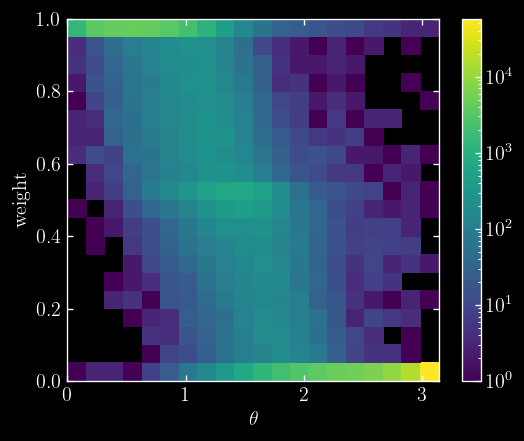

In [71]:
from matplotlib.colors import LogNorm
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi=120)
minpt = 0
theta_ = np.concatenate(theta[pt>minpt]).flatten()
weights_ = np.concatenate(weights[pt>minpt]).flatten()
plt.hist2d(theta_,weights_,bins=20,norm=LogNorm())
plt.xlabel(r"$\theta$")
plt.ylabel("weight")
plt.xlim([0,np.pi])
plt.colorbar()
plt.show()

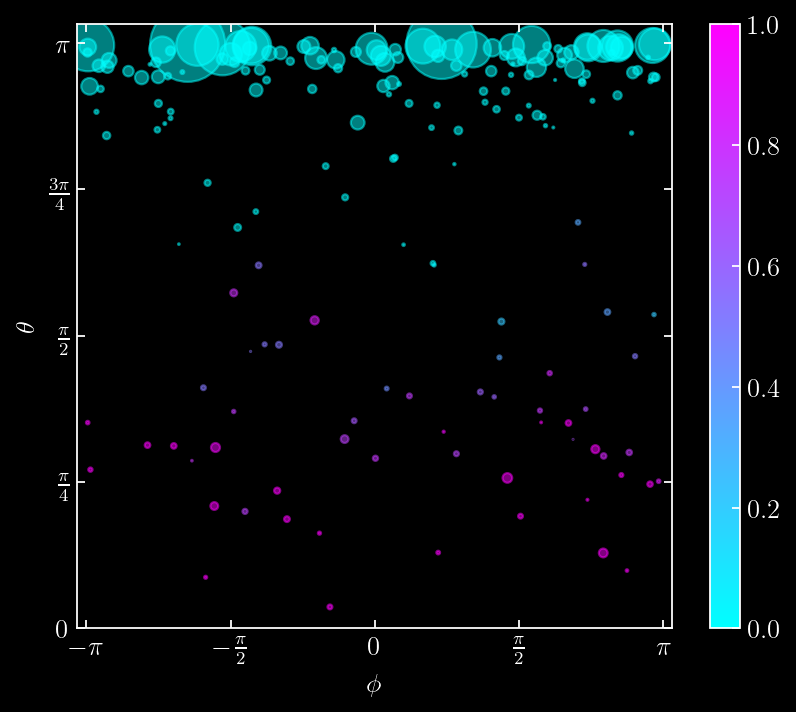

In [101]:
from matplotlib import cm
def build_plot():
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$\theta$')
    plt.xlim([-np.pi-0.1,np.pi+0.1])
    plt.ylim([0,np.pi+0.1])
    plt.xticks(ticks=np.linspace(-np.pi,np.pi,5),labels=[r'$-\pi$',r'$-\frac{\pi}{2}$',0,r'$\frac{\pi}{2}$',r'${\pi}$'])
    plt.yticks(ticks=np.linspace(0,np.pi,5),labels=[0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'${\pi}$'])
    plt.colorbar(cm.ScalarMappable(cmap=cmap))
    plt.show()

minpt = 10.5
maxpt = 21
cond = (pt>minpt)&(pt<maxpt)
weights_ = np.concatenate(weights[cond]).flatten()
theta_ = np.concatenate(theta[cond]).flatten()
phi_ = np.concatenate(phi[cond]).flatten()
E_ = np.concatenate(E[cond]).flatten()

cmap = cm.cool
colors = cmap(weights_)
fig,ax = plt.subplots(1,1,figsize=(6,5), dpi=160)
plt.scatter(phi_,theta_, alpha = 0.5, s=E_*10, c=colors)
build_plot()

In [72]:
len(weights_)

159473

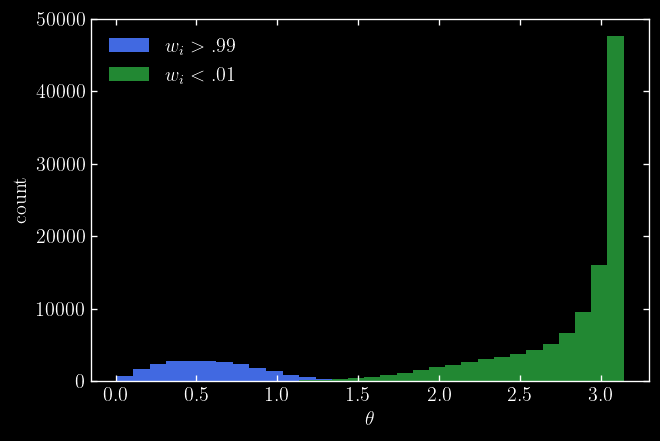

In [75]:
fig,ax = plt.subplots(1,1,figsize=(6,4), dpi=120)
plt.hist(theta_[weights_>.99],label=r'$w_i>.99$',bins=30)
plt.hist(theta_[weights_<.01],label=r'$w_i<.01$',bins=30)
plt.xlabel(r"$\theta$")
plt.ylabel("count")
plt.legend()
plt.show()